## Use Timestamp Data

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import json
import os

from explorer import *

DATA_PATH ='./gadata/'

In [2]:
PROJECT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_name, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_name + "." + fig_extension)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    print("Figure saved,", fig_name)
    
    
print("Number of Users: %d"%len(list(retrieve_files(DATA_PATH))))

Number of Users: 6106


In [3]:
# Load json data into pandas dataframe
raw_journey = combine_journey_data(DATA_PATH) # Dataframe containing user pageview journeys

### Use Browing Time as Rating Proxy

In [4]:
# Make a copy of oringinal dataset
data = raw_journey.copy()

In [5]:
# Convert time featture into datetime 
data['datetime'] = data['date'] + ' ' + data['time']
data['datetime'] = pd.to_datetime(data['datetime'])

# Calculate the time difference between each page
data['duration'] = - data.groupby('uid')['datetime'].diff(periods=1)

In [6]:
def days_minutes(td):
    """convert timedelta into days and minutes"""
    return td.days, td.seconds//3600 * 60 + (td.seconds//60)%60

def day_gap(x):
    if abs(days_minutes(x)[0]) > 1:
        y = np.nan
    else:
        y = days_minutes(x)[1]
    return y

In [7]:
# Convert time difference into minutes
data['dur_mins'] = data['duration'].map(day_gap)
# Preprocess pageURL column
data['pageURL'] = data['pageURL'].replace('', np.nan)
# Backfill missing data
data['pageURL'] = data['pageURL'].fillna(method='bfill')

In [8]:
data.head()

,uid,date,time,page,pageURL,eventAction,datetime,duration,dur_mins
0,06ad34da38ae4e93bae9839fa38e5c2f,"Jan 8, 2021",3:26 PM,If caught with drugs - The Mix,/drink-and-drugs/drugs-and-the-law/if-caught-w...,,2021-01-08 15:26:00,NaT,NaN
1,06ad34da38ae4e93bae9839fa38e5c2f,"Jan 8, 2021",1:45 PM,,/drink-and-drugs/drugs-and-the-law/if-caught-w...,time on page more than 30 seconds,2021-01-08 13:45:00,0 days 01:41:00,101.0
2,06ad34da38ae4e93bae9839fa38e5c2f,"Jan 8, 2021",1:45 PM,If caught with drugs - The Mix,/drink-and-drugs/drugs-and-the-law/if-caught-w...,,2021-01-08 13:45:00,0 days 00:00:00,0.0
3,000708d176f8010cb95adfa271ad797d,"Jan 24, 2021",2:00 AM,,/crime-and-safety/in-trouble/being-taken-to-sm...,time on page more than 30 seconds,2021-01-24 02:00:00,NaT,NaN
4,000708d176f8010cb95adfa271ad797d,"Jan 24, 2021",1:59 AM,Being taken to small claims court - The Mix,/crime-and-safety/in-trouble/being-taken-to-sm...,,2021-01-24 01:59:00,0 days 00:01:00,1.0


### Clean pageurl to remove customized and sensitive pages

In [9]:
def clean_url_col(text):
    """Clean pages that are specific to a user"""
    # Ignore user searched page
    text = re.sub(r"(^\/search.*)", '', text)
    text = re.sub(r"(\?.*$)", '', text)
    text = re.sub('\/,', '/', text)
    text = re.sub(r"(^\/get-support\/find-local-services.*)", "/get-support/find-local-services", text)
    text = re.sub(r"(^\/post\/editdiscussion.*)", '/post/editdiscussion', text)
    text = re.sub(r"(^\/get-involved\/support-us.*)", '/get-involved/support-us', text)
    text = re.sub(r"(^.*course.*)", '/course', text)
    text = re.sub(r"(^.*mod.*)", '/mod', text)
    # Ignore user setting pages
    text = re.sub(r"(^\/profile.*)", '', text)
    text = re.sub(r"(^\/message.*)", '/message', text)
    text = re.sub(r"(^\/draft.*)", '', text)
    text = re.sub(r"(^\/login.*)", '', text)
    text = re.sub(r"(^\/user.*)", '', text)
    text = re.sub(r"(^.*forgotten-password.*)", "", text)
    
    return text

In [10]:
# Apply text cleaning to pageURL
data['pageURL'] = data['pageURL'].apply(clean_url_col)

### User percentile to create ratings

In [11]:
# Remove user-item duplicates entries
# Sum up the total time a user spend on a page
data_cleaned = data.groupby(['uid', 'pageURL'], 
                            as_index=False).agg({'datetime':'first', 'page': 'last', 'dur_mins': 'sum'})
# Cap the maximum duration to 30 minutes
data_cleaned['dur_mins'] = np.clip(data_cleaned['dur_mins'], a_max=30, a_min=0.5)

In [12]:
from scipy import stats
dur_mins = data_cleaned['dur_mins'].values

score = [stats.percentileofscore(dur_mins, a, 'rank') for a in dur_mins]
# Make ratings between 0 and 1
score = [ele/100 for ele in score]
data_cleaned['interest'] = score

In [13]:
# Remove blank entries
data_cleaned = data_cleaned[['uid', 'page', 'pageURL', 'datetime', 'interest']]
data_cleaned = data_cleaned[data_cleaned['page'] != 'Page Not Found - The Mix']
data_cleaned = data_cleaned[data_cleaned.pageURL != '']
data_cleaned = data_cleaned[data_cleaned.page != '']

In [14]:
data_cleaned.isna().sum()

uid         0
page        0
pageURL     0
datetime    0
interest    0
dtype: int64

In [15]:
data_cleaned = data_cleaned[data_cleaned.page != '']

### Build Item Feature

In [16]:
def create_feature(text):
    text = re.sub('^\/discussion.*', 'discussion', text)
    text = re.sub('^\/disussion.*', 'discussion', text)
    text = re.sub('^\/vanilla/discussion.*', 'discussion', text)
    text = re.sub('.*\/group-chat.*', 'chat', text)
    text = re.sub('^\/categories.*', 'community', text)
    text = re.sub('^\/activity.*', 'community', text)
    text = re.sub('^\/message.*', 'community', text)
    text = re.sub('^\/badge.*', 'community', text)
    text = re.sub('^\/post.*', 'community', text)
    text = re.sub('^\/report\/progress.*', 'community', text)
    
    text = re.sub('^\/get-support.*', 'support', text)
    text = re.sub('^\/brexit-euss-support.*', 'brexit support', text)
    text = re.sub('^\/coronavirus-support.*', 'coronavirus support', text)
    text = re.sub('^\/loneliness-support.*', 'loneliness support', text)
    text = re.sub('^\/brexit-eu-settlement-scheme-support.*', 'brexit support', text)
    text = re.sub('^\/young-carers.*', 'youngcarer support', text)
    text = re.sub('^\/bullying-support.*', 'support', text)
    text = re.sub('^\/self-harm-awareness-day.*', 'self-harm support', text)
    text = re.sub('^\/local.*', 'support', text)
    text = re.sub('^\/relationship-advice.*', 'relationship advice', text)
    text = re.sub('^\/services\/one-to-one-chat.*', 'chat', text)
    
    text = re.sub('.*.html$', 'article', text)
    text = re.sub('^\/mental-health.*', 'article', text)
    text = re.sub('^\/money.*', 'article', text)
    text = re.sub('^\/drink-and-drugs.*', 'article', text)
    text = re.sub('^\/travel-and-lifestyle.*', 'article', text)
    text = re.sub('^\/housing.*', 'article', text)
    text = re.sub('^\/work-and-study.*', 'article', text)
    text = re.sub('^\/your-body.*', 'article', text)
    text = re.sub('^\/crime-and-safety.*', 'article', text)
    text = re.sub('^\/coronavirus-and-mental-health.*', 'article', text)
    text = re.sub('^\/sex-and-relationships.*', 'article', text)
    text = re.sub('^\/tag.*', 'article', text)
    text = re.sub('^\/news-and-research.*', 'news', text)
    text = re.sub('^\/edit-profile', 'login', text)
    text = re.sub('^\/entry', 'login', text)
    text = re.sub('^\/log-in.*', 'login', text)
    text = re.sub('^.*login.*', 'login', text)
    text = re.sub('^\/sign-up.*', 'login', text)
    text = re.sub('^\/reset-password.*', 'login', text)
    text = re.sub('^\/admin.*', 'login', text)
    text = re.sub('^\/about-us.*', 'mixinfo', text)
    text = re.sub('^\/$', 'mixinfo', text)
    text = re.sub('^\/services\/counselling-services', 'mixinfo', text)
    text = re.sub('^\/partner\/counselling-from-the-mix', 'mixinfo', text)
    text = re.sub('^\/services\/telephone-counselling', 'mixinfo', text)
    text = re.sub('^\/services\/telephone-counselling', 'mixinfo', text)
    text = re.sub('^\/lib\/editor\/atto\/plugins.*', 'mixinfo', text)
    text = re.sub('^\/quartlerly-data-trends.*', 'mixinfo', text)
    text = re.sub('^\/brexit.*', 'mixinfo', text)
    text = re.sub('^\/trusted-information.*', 'mixinfo', text)
    
    text = re.sub('^\/mod.*', 'volunteer', text)
    text = re.sub('.*course.*', 'course', text)
    text = re.sub('^\/enrol.*', 'course', text)
    text = re.sub('^\/calendar.*', 'course', text)
    text = re.sub('^\/index.*', 'course', text)
    text = re.sub('^\/my\/.*', 'course', text)

    text = re.sub('^\/apps-and-tools.*', 'apps', text)
    text = re.sub('^\/home-truths.*', 'apps', text)
    text = re.sub('^\/get-involved.*', 'participation', text)
    text = re.sub('^\/get_involved.*', 'participation', text)
    text = re.sub('^\/body-and-soul-club.*', 'volunteer', text)
    text = re.sub('^\/digital-families.*', 'support', text)
    text = re.sub('.*digital families.*', 'support', text)
    text = re.sub('^\/your-voices.*', 'voices', text)
    text = re.sub('^\/bestof/everything.*', 'voices', text)
    
    return text

In [17]:
# Create item features
data_cleaned['category'] = data_cleaned['pageURL'].apply(create_feature)

In [18]:
# Check if all pages are categorized
data_cleaned['category'].unique()

array(['article', 'mixinfo', 'discussion', 'support', 'participation',
       'voices', 'community', 'chat', 'volunteer', 'login', 'apps',
       'news', 'youngcarer support', 'course', 'coronavirus support',
       'brexit support', 'loneliness support', 'self-harm support',
       'relationship advice'], dtype=object)

### Save cleaned data 

In [19]:
data_cleaned.to_csv('cleaned.csv', index=False)

#### Create Article Tags

In [20]:
with open('article.txt', 'r') as reader:
    article_dict = json.loads(reader.read()) 

In [21]:
pairs = []

for tag, names in article_dict.items():
    size = len(names)
    pairs.extend(list(zip([tag]*size, names)))

# Remove empty values
pairs = [t for t in pairs if t[1]!='']

In [22]:
def tag_mapper(search_text):
    for tag, name in pairs:
        if name == search_text:
            return tag

In [23]:
def clean_text(text):
    text = text.split('-')[0].strip()
    text = re.sub('[^a-zA-Z]', ' ', text)
    # Convert to lowercase
    text = text.lower()
    # Remove tags
    text = re.sub("&lt;/?.*?&gt;", " &lt;&gt; ", text)
    # Remove special characters and digits
    text = re.sub("(\\d|\\W)+", " ", text)
    text = text.strip()
    return text

In [24]:
article_tag = data_cleaned.copy()[['pageURL', 'page']]
article_tag['page'] = article_tag.page.map(clean_text)
article_tag['tag'] = article_tag.page.map(tag_mapper)

article_tag.to_csv('article_tag.csv', index=False)

#### Plot Item Category

In [25]:
data_cleaned.shape

(32795, 6)

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import random


def plot_piechart(col_name, data, explode=None):
    plt.style.use("ggplot")
    plt.rcParams["figure.figsize"] = [7, 7]
    plt.rcParams["figure.autolayout"] = True
    n = data[col_name].nunique()
    slices = data[col_name].value_counts().values
    activities = data[col_name].value_counts().index
    # Create color codes to avoid color cycle
    colors = ["#" + ''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(n)]

    patches, texts = plt.pie(slices,
       colors=colors,
       startangle=90,
       labels=activities, explode=explode)

    labels = ['{0} - {1:1.2f} %'.format(i, j) for i, j in zip(activities,
    100.*slices/slices.sum())]
    plt.legend(patches, labels, loc='center left', bbox_to_anchor=(-0.6, .5), fontsize=8)

    centre_circle = plt.Circle((0,0),0.70,fc='white')
    f = plt.gcf()
    f.gca().add_artist(centre_circle)
    # Equal aspect ratio ensures that pie is drawn as a circle
    plt.tight_layout()
    plt.show()

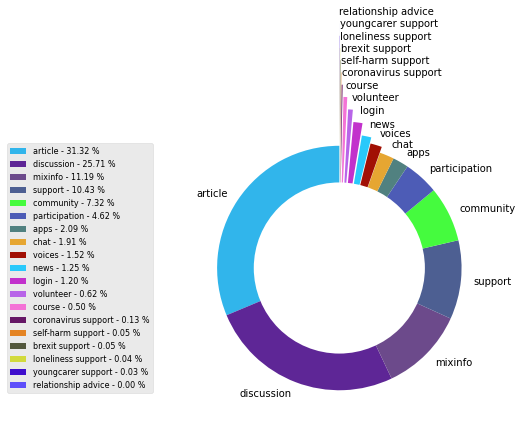

In [27]:
explode = (0,0,0,0,0,0,0,0,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1)
plot_piechart('category', data_cleaned, explode)

In [115]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

In [116]:
page_df = pd.read_csv('cleaned.csv', encoding='utf-8')[['pageURL', 'page', 'category']].set_index('pageURL')
page_df2 = pd.read_csv('article_tag.csv')[['pageURL', 'tag']].set_index('pageURL')
page_df = pd.concat([page_df, page_df2], axis=1 )
page_df = page_df.reset_index()

subset_df = page_df[page_df.tag.isna() ]
page_df = page_df[~page_df.tag.isna() ]
page_df['category'] = page_df[['category', 'tag']].agg('-'.join, axis=1)
page_df = pd.concat([page_df, subset_df], axis=0)
page_df = page_df[['pageURL', 'page', 'category']]

page_df.drop_duplicates(subset=['pageURL'], inplace=True)
page_df['article_page'] = page_df['category'].apply(lambda x: x.startswith('article-'))
article_df = page_df[page_df.article_page==True]
article_df 

,pageURL,page,category,article_page
0,/drink-and-drugs/drugs-and-the-law/if-caught-w...,If caught with drugs - The Mix,article-drugs and the law,True
1,/crime-and-safety/in-trouble/being-taken-to-sm...,Being taken to small claims court - The Mix,article-money rights,True
2,/money/money-rights/taking-someone-to-small-cl...,Taking someone to small claims court - The Mix,article-housing problems,True
3,/sex-and-relationships/having-sex/fingering-a-...,Fingering a girl - TheMix.org.uk,article-having sex,True
4,/sex-and-relationships/having-sex/why-does-she...,Why does she bleed when I finger her? - TheMix...,article-having sex,True
...,...,...,...,...
32076,/sex-and-relationships/family-life/family-ther...,Family therapy - The Mix,article-family life,True
32537,/mental-health/looking-after-yourself/i-want-t...,I want to make the most of my time - The Mix,article-looking after yourself,True
32595,/your-body/body-problems/sickle-cell-anaemia-7...,Sickle Cell Anaemia - The Mix,article-body problems,True
32661,/work-and-study/student-life/depression-at-uni...,Depression at university - The Mix,article-student life,True


In [117]:
article_df['category'] = article_df['category'].apply(lambda x: x.split('-')[1])

<ipython-input-117-ebd2e0294460>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  article_df['category'] = article_df['category'].apply(lambda x: x.split('-')[1])


In [118]:
def plot_piechart(col_name, data, explode=None):
    plt.style.use("ggplot")
    plt.rcParams["figure.figsize"] = [7, 7]
    plt.rcParams["figure.autolayout"] = True
    n = data[col_name].nunique()
    slices = data[col_name].value_counts().values
    activities = data[col_name].value_counts().index
    # Create color codes to avoid color cycle
    colors = ["#" + ''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(n)]

    patches, texts = plt.pie(slices,
       colors=colors,
       startangle=90,
       labels=activities, explode=explode)

    labels = ['{0} - {1:1.2f} %'.format(i, j) for i, j in zip(activities,
    100.*slices/slices.sum())]
    plt.legend(patches, labels, loc='center left', bbox_to_anchor=(-1, .5), fontsize=8)

    centre_circle = plt.Circle((0,0),0.70,fc='white')
    f = plt.gcf()
    f.gca().add_artist(centre_circle)
    # Equal aspect ratio ensures that pie is drawn as a circle
    plt.tight_layout()
    plt.show()

In [123]:
art_viz = article_df.category.value_counts()[:20]

sub_article_df = article_df[article_df.category.isin(art_viz.index)]

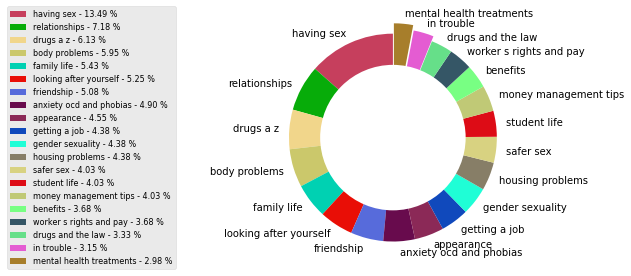

In [127]:
# explode = (0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.05,0.1)
plot_piechart('category', sub_article_df, explode=explode)

## Making Recommendations using Networkx

In [1]:
import pandas as pd
import numpy as np
import datetime
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import networkx as nx
from nxviz import CircosPlot

In [2]:
# Load the data
full_df = pd.read_csv("./cleaned.csv", parse_dates=['datetime'])
df = full_df[['uid',  'pageURL', 'datetime']]
page_df = full_df[['pageURL','page']]

In [3]:
df.datetime.max()

Timestamp('2021-05-26 23:22:00')

In [4]:
df[df.pageURL=='/get-support']

,uid,pageURL,datetime
10,00328efeb249f607b41564c486a73322,/get-support,2020-05-26 13:47:00
64,00507ad2fe00eb029c6193e0972c9845,/get-support,2020-10-24 17:04:00
69,005db6ac47d4db3fa9b056566e04190a,/get-support,2020-10-24 18:12:00
105,00730edea1dafb3ec9d6e60c8194ef58,/get-support,2020-08-30 16:33:00
222,00eee69c2f3b51267142dde6e59b93f9,/get-support,2020-11-26 16:18:00
...,...,...,...
32671,fefb94bb411e893bf1adfc57b3f9ae09,/get-support,2021-01-29 10:32:00
32709,ff2a8c23e690de71612ec5fc0c68834a,/get-support,2020-12-08 17:27:00
32734,ff88dd19ed3c5d2b3a9bb4cf2c523896,/get-support,2020-09-03 13:31:00
32765,ffc64602a833978e3ad14423a4ea9b2a,/get-support,2020-04-22 17:09:00


In [5]:
G = nx.Graph()

G.add_nodes_from(df['uid'], bipartite='user')
G.add_nodes_from(df['pageURL'],  bipartite='page')

for r, d in df.iterrows():
    G.add_edge(d['uid'], d['pageURL'], data=d['datetime'])

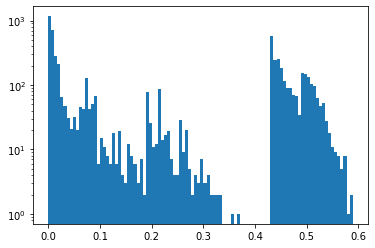

In [6]:
# Get the user partition's nodes: student_nodes
user_nodes = [n for n, d in G.nodes(data=True) if d['bipartite'] == 'user']

# Create the user nodes projection as a graph: G_user
G_users = nx.bipartite.projected_graph(G, nodes=user_nodes)

# Calculate the degree centrality using nx.degree_centrality: dcs
dcs = nx.degree_centrality(G_users)
# Plot the histogram of degree centrality values
plt.hist(list(dcs.values()), bins=100)
plt.yscale('log')  
plt.show() 

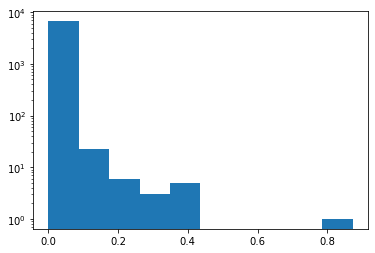

In [7]:
# Get the forums partition's nodes: forum_nodes
page_nodes = [n for n,d in G.nodes(data=True) if d['bipartite']=='page']
# Create the page nodes projection as a graph: G_pages
G_pages = nx.bipartite.projected_graph(G, page_nodes)
# Calculate the degree centrality using nx.degree_centrality: dcs
dcs = nx.degree_centrality(G_pages)
# Plot the histogram of degree centrality values
plt.hist(list(dcs.values()))
plt.yscale('log') 
plt.show()  

In [8]:
def shared_partition_nodes(G, node1, node2):
    # Check that the nodes belong to the same partition
    assert G.nodes[node1]['bipartite'] == G.nodes[node2]['bipartite']
    # Get neighbors of node 1: nbrs1
    nbrs1 = G.neighbors(node1)
    # Get neighbors of node 2: nbrs2
    nbrs2 = G.neighbors(node2)
    # Compute the overlap using set intersections
    overlap = set(nbrs1).intersection(nbrs2)
    return overlap
# Print the number of shared repositories between users 
user_1 = '00328efeb249f607b41564c486a73322'
user_2 = '00730edea1dafb3ec9d6e60c8194ef58'
print(f"Number of pages shared by user {user_1} and {user_2}: {len(shared_partition_nodes(G, user_1, user_2 ))}")

Number of pages shared by user 00328efeb249f607b41564c486a73322 and 00730edea1dafb3ec9d6e60c8194ef58: 1


In [32]:
def user_similarity(G, user1, user2, proj_nodes):
    # Check that the nodes belong to the 'users' partition
    assert G.nodes[user1]['bipartite'] == 'user'
    assert G.nodes[user2]['bipartite'] == 'user'
    # Get the set of nodes shared between the two users
    shared_nodes = shared_partition_nodes(G, user1, user2)
    # Return the fraction of nodes in the projects partition
    return len(shared_nodes) / len(proj_nodes)

# Compute the similarity score between users 
similarity_score = user_similarity(G, user_1, user_2, page_nodes)
print(similarity_score)

0.00014885382554331647


In [33]:
from collections import defaultdict
def most_similar_users(G, user, user_nodes, proj_nodes):
    # Data checks
    assert G.nodes[user]['bipartite'] == 'user'
    # Get other nodes from user partition
    user_nodes = set(user_nodes)
    user_nodes.remove(user)
    # Create the dictionary: similarities
    similarities = defaultdict(list)
    for n in user_nodes:
        similarity = user_similarity(G, user, n, proj_nodes)
        similarities[similarity].append(n)
    # Compute maximum similarity score: max_similarity
    max_similarity = max(similarities.keys())
    # Return list of users that share maximal similarity
    return similarities[max_similarity]


user_id = 'fefb94bb411e893bf1adfc57b3f9ae09'
print(most_similar_users(G, user_id, user_nodes, page_nodes))

['47677e52d2be9334b8a453278a5b72b0', '956f16d1f0836ba11bb49a65a9f7010f', '6868775f7b1d8b201012bb4bf09b2240']


In [34]:
page_df

,pageURL,page
0,/drink-and-drugs/drugs-and-the-law/if-caught-w...,If caught with drugs - The Mix
1,/crime-and-safety/in-trouble/being-taken-to-sm...,Being taken to small claims court - The Mix
2,/money/money-rights/taking-someone-to-small-cl...,Taking someone to small claims court - The Mix
3,/sex-and-relationships/having-sex/fingering-a-...,Fingering a girl - TheMix.org.uk
4,/sex-and-relationships/having-sex/why-does-she...,Why does she bleed when I finger her? - TheMix...
...,...,...
32790,/get-support,Get Support - The Mix
32791,/get-support/speak-to-our-team,Speak to Our Team - The Mix
32792,/get-support/speak-to-our-team/crisis-messenger,Crisis Messenger - The Mix
32793,/sex-and-relationships/having-sex/is-my-penis-...,Is my penis normal? - TheMix.org.uk


In [35]:
def recommend_pages(G, from_user, to_user):
    # Get the set of pages that from_user has viewed
    from_pages = set(G.neighbors(from_user))
    # Get the set of pages that to_user has viewed
    to_pages = set(G.neighbors(to_user))
    # Identify pages that the from_user is connected to that the to_user is not connected to
    return from_pages.difference(to_pages)


from_user = 'fefb94bb411e893bf1adfc57b3f9ae09'
to_user = '6868775f7b1d8b201012bb4bf09b2240'
# Print the pages to be recommended
for i, pageURL in enumerate(recommend_pages(G, from_user, to_user)):
    page = page_df[page_df.pageURL == pageURL]['page'].values[0]
    print(f"{i+1}-{page}")

1-How to resign - The Mix
2-Sex & Relationships - The Mix
3-Mental Health Treatments - Page 2 of 4 - The Mix
4-How to cope when a friendship ends - The Mix
5-Your Voices Guidelines - The Mix
6-Mental Health Treatments - Page 3 of 4 - The Mix
7-Resources - The Mix
8-Ambassador voices: Fuck the 'lockdown glow-up'! - The Mix
9-How to talk about your mental health - The Mix


In [45]:
# Compute the biadjacency matrix: bi_matrix
bi_matrix = nx.bipartite.biadjacency_matrix(G, row_order=user_nodes, column_order=page_nodes)
# Compute the user-user projection: user_matrix
user_matrix = bi_matrix @ bi_matrix.T

In [46]:
diag = user_matrix.diagonal() 
indices = np.where(diag == diag.max())[0]  
print('Number of pages: {}'.format(diag.max()))
print('User with the most number of pages:')
for i in indices:
    print('- {0}'.format(user_nodes[i]))
# Set the diagonal to zero and convert it to a coordinate matrix format
user_matrix.setdiag(0)
users_coo = user_matrix.tocoo()
# Find pairs of users who shared pages in the most number of pages
indices2 = np.where(users_coo.data == users_coo.data.max())[0]
print(f'\nHighest number of shared page: {users_coo.data.max()}\n')
print('User with most number of shared pages:')
for idx in indices2:
    print('- {0}, {1}'.format(user_nodes[users_coo.row[idx]], user_nodes[users_coo.col[idx]]))  

Number of pages: 83
User with the most number of pages:
- a7d5c96e7a220c556c804df4125180f6

Highest number of shared page: 23

User with most number of shared pages:
- 3fb6f5d560e3555170a1cafebc3657f0, 6e99e8a3263325890f09efe0247dd58c
- 6e99e8a3263325890f09efe0247dd58c, 3fb6f5d560e3555170a1cafebc3657f0


In [38]:
# Initialize a list to store each edge as a record: nodelist
nodelist = []
for n, d in G_users.nodes(data=True):
    # nodeinfo stores one "record" of data as a dict
    nodeinfo = {'user': n} 
    
    # Update the nodeinfo dictionary 
    nodeinfo.update(d)
    
    # Append the nodeinfo to the node list
    nodelist.append(nodeinfo)
    
# Create a pandas DataFrame of the nodelist: node_df
node_df = pd.DataFrame(nodelist)
print(node_df.head())

                                user bipartite
0   06ad34da38ae4e93bae9839fa38e5c2f      user
1   000708d176f8010cb95adfa271ad797d      user
2   001291be71d38604bc02f7c469b80704      user
3   00310de616cf03e7740b739ead30aed2      user
4   00328efeb249f607b41564c486a73322      user


In [39]:
# Initialize a list to store each edge as a record: edgelist
edgelist = []
for n1, n2, d in G_users.edges(data=True):
    # Initialize a dictionary that shows edge information: edgeinfo
    edgeinfo = {'node1':n1, 'node2':n2}
    
    # Update the edgeinfo data with the edge metadata
    edgeinfo.update(d)
    
    # Append the edgeinfo to the edgelist
    edgelist.append(edgeinfo)
    
# Create a pandas DataFrame of the edgelist: edge_df
edge_df = pd.DataFrame(edgelist)
print(edge_df.head())

                               node1                             node2
0   06ad34da38ae4e93bae9839fa38e5c2f  fcb44c00a928db295071399d2af9efb9
1   06ad34da38ae4e93bae9839fa38e5c2f  bd5a9247743e01a7cd08583ff65732e9
2   06ad34da38ae4e93bae9839fa38e5c2f  7276c72193e209fec1644c2021b37efb
3   06ad34da38ae4e93bae9839fa38e5c2f  4ae5d65ceb98ebf79fe0dd5923f4cae3
4   06ad34da38ae4e93bae9839fa38e5c2f  3e8b86b8581213e72e137011aa4d052a


In [48]:
# Instantiate a new graph: G_sub
G_sub = nx.Graph()
# Add nodes from the original graph
G_sub.add_nodes_from(G.nodes(data=True))
# Add edges 
G_sub.add_edges_from([(u, v, d) for u, v, d in G.edges(data=True) if d['data'] > datetime(2021,5,1)])

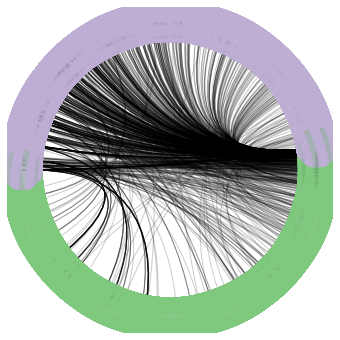

<Figure size 1152x1152 with 0 Axes>

In [49]:
# Compute degree centrality scores of each node
dcs = nx.bipartite.degree_centrality(G, nodes=page_nodes)
for n, d in G_sub.nodes(data=True):
    G_sub.nodes[n]['dc'] = dcs[n]
# Create the CircosPlot object: c
c = CircosPlot(G_sub, node_color='bipartite', node_grouping='bipartite',
node_order='dc')
# Draw c to screen
c.draw()
# Display the plot
plt.show() 

In [105]:
# Define current day and timedelta of 2 days
dayone = datetime(2020, 1, 1, 0, 0)
lastday = datetime(2021, 5, 6, 23, 22)

curr_day = dayone
td = timedelta(1)
# Initialize an empty list of posts by day
n_pages = []
while curr_day < lastday:
    if curr_day.day == 1:
        print(curr_day) 
    # Filter edges such that they are within the sliding time window: edges
    edges = [(u, v, d) for u, v, d in G.edges(data=True) if d['data'] >= curr_day and d['data'] < curr_day + td]
    
    # Append number of edges to the n_pages list
    n_pages.append(len(edges))
    
    # Increment the curr_day by the time delta
    curr_day += td

2020-01-01 00:00:00
2020-02-01 00:00:00
2020-03-01 00:00:00
2020-04-01 00:00:00
2020-05-01 00:00:00
2020-06-01 00:00:00
2020-07-01 00:00:00
2020-08-01 00:00:00
2020-09-01 00:00:00
2020-10-01 00:00:00
2020-11-01 00:00:00
2020-12-01 00:00:00
2021-01-01 00:00:00
2021-02-01 00:00:00
2021-03-01 00:00:00
2021-04-01 00:00:00
2021-05-01 00:00:00


In [106]:
(lastday - dayone)

datetime.timedelta(days=491, seconds=84120)

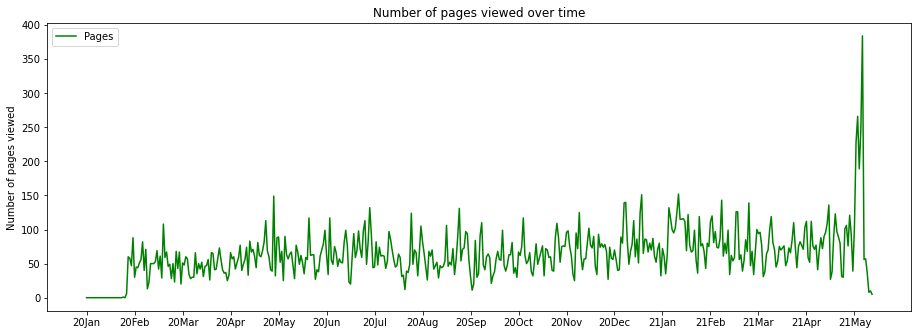

In [136]:
fig = plt.figure()
ax = fig.add_axes([0,0,2,1])
y = n_pages
x = range(len(n_pages))
ax.plot(x,y, color='green', label='Pages')
ax.set_xticks([0,30,60,90,120,150,180,210,240,270,300,330,360,390,420,450,480])
ax.set_xticklabels(['20Jan','20Feb','20Mar','20Apr','20May', '20Jun', '20Jul', '20Aug', '20Sep', '20Oct', '20Nov', '20Dec',
                   '21Jan','21Feb','21Mar','21Apr','21May'])
plt.ylabel('Number of pages viewed')
plt.title('Number of pages viewed over time')
plt.legend()
plt.show()

In [111]:
most_popular_pages = []
highest_dcs = []
curr_day = dayone 
td = timedelta(days=1)  
while curr_day < lastday:  
    if curr_day.day == 1:  
        print(curr_day)  
    G_sub = nx.Graph()
    G_sub.add_nodes_from(G.nodes(data=True))   
    G_sub.add_edges_from([(u, v, d) for u, v, d in G.edges(data=True) if d['data'] >= 
                          curr_day and d['data'] < curr_day + td])
    
    # Get the degree centrality 
    dc = nx.bipartite.degree_centrality(G_sub, page_nodes)
    # Filter the dictionary such that there's only forum degree centralities
    page_dcs = {n:dc for n, dc in dc.items() if n in page_nodes}
    # Identify the most popular forum(s) 
    most_popular_page = [n for n, dc in dc.items() if dc == max(page_dcs.values()) and dc != 0] 
    most_popular_pages.append(most_popular_page) 
    # Store the highest dc values in highest_dcs
    highest_dcs.append(max(page_dcs.values()))
    
    curr_day += td  

2020-01-01 00:00:00
2020-02-01 00:00:00
2020-03-01 00:00:00
2020-04-01 00:00:00
2020-05-01 00:00:00
2020-06-01 00:00:00
2020-07-01 00:00:00
2020-08-01 00:00:00
2020-09-01 00:00:00
2020-10-01 00:00:00
2020-11-01 00:00:00
2020-12-01 00:00:00
2021-01-01 00:00:00
2021-02-01 00:00:00
2021-03-01 00:00:00
2021-04-01 00:00:00
2021-05-01 00:00:00


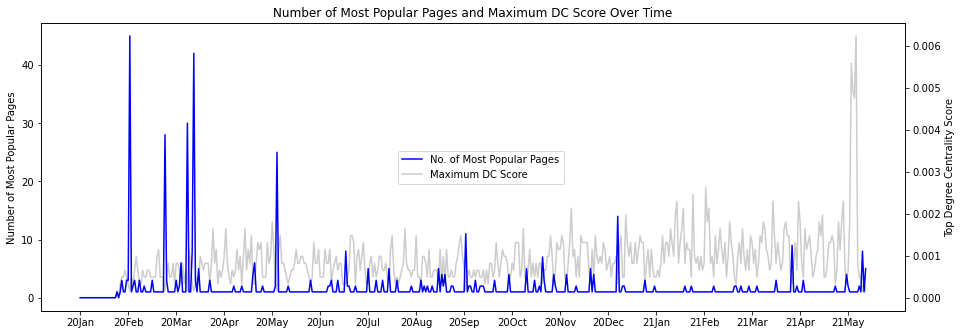

In [207]:
fig = plt.figure()
ax1 = fig.add_axes([0,0,2,1])
y = [len(pages) for pages in most_popular_pages]
x = range(len(most_popular_pages))
ax1.plot(x,y, color='blue', label='No. of Most Popular Pages')
ax1.set_xticks([0,30,60,90,120,150,180,210,240,270,300,330,360,390,420,450,480])
ax1.set_xticklabels(['20Jan','20Feb','20Mar','20Apr','20May', '20Jun', '20Jul', '20Aug', '20Sep', '20Oct', '20Nov', '20Dec',
                   '21Jan','21Feb','21Mar','21Apr','21May'])
ax1.set_ylabel('Number of Most Popular Pages')
ax2 = ax1.twinx()
ax2.plot(x, highest_dcs,'k', alpha=0.2, label='Maximum DC Score')
ax2.set_ylabel('Top Degree Centrality Score')

plt.title('Number of Most Popular Pages and Maximum DC Score Over Time')
fig.legend(loc='center')
plt.show()

In [135]:
# fig = plt.figure()
# ax = fig.add_axes([0,0,2,1])
# y = highest_dcs
# x = range(len(most_popular_pages))
# ax.plot(x,y, color='orange', label='Page DC Score')
# ax.set_xticks([0,30,60,90,120,150,180,210,240,270,300,330,360,390,420,450,480])
# ax.set_xticklabels(['20Jan','20Feb','20Mar','20Apr','20May', '20Jun', '20Jul', '20Aug', '20Sep', '20Oct', '20Nov', '20Dec',
#                    '21Jan','21Feb','21Mar','21Apr','21May'])
# plt.ylabel('Top Degree Centrality Score')
# plt.title('Top Degree Centrality Score (Page) over time')
# plt.legend()
# plt.show()

## Sample page networks

In [165]:
import os
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import networkx as nx

PROJECT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_name, tight_layout=True, fig_extension="png", resolution=50):
    path = os.path.join(IMAGES_PATH, fig_name + "." + fig_extension)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    print("Figure saved,", fig_name)

In [166]:
# Drop NA values from node and link columns
def clean_data(df,node,link, node_minimum_nchar, link_minimum_nchar):
    df = df.dropna(subset=[link])
    df[node] = df[node].map(str)
    df[link] = df[link].map(str)
    df = df[(df[node].map(len)>node_minimum_nchar) & (df[link].map(len)>link_minimum_nchar)]
    return(df)

#Remove Node_Link combinations
def remove_duplicate_node_link(df,node,link):
    df['node_link'] = df[node].map(str)+df[link].map(str)
    df = df.drop_duplicates(subset=['node_link'])
    return(df)

# Links per unique node (feature creation)
# Find number of links per unique node
def links_per_node(df,node,link):
    df=df.pivot_table(link, node,aggfunc=len,)
    s = pd.DataFrame(df.index)
    t = pd.DataFrame(df.values)
    lpn = pd.concat([s, t], axis=1)
    lpn.columns=[node, 'NumberOfLinks']
    return(lpn)
# Merge links per node width original dataframe
def add_links_per_node(df,node,link):
    return(df.merge(links_per_node(df,node,link),on=node,how='left'))

# Get duplicated users to make sure they link atleast 2 artists
def get_duplicated_links(df,link):
    ids = df[df[link].duplicated()][link].reset_index()
    new_df =  df[df[link].isin(ids[link])]
    return(new_df)

# Get unique artist_x - user - artist_y rows
def get_unique_node_link_node_grouping(df,node,link,node_x,node_y):
    # Get from - to groupings
    new_df = df.merge(df,on = link)
    # Drop duplicate node_x-link-node_y rows
    new_df['ordered_nodes'] = new_df.apply(lambda x: '-'.join(sorted([x[node_x],x[link],x[node_y]])),axis=1)
    new_df = new_df.drop_duplicates(['ordered_nodes'])
    # Drop node_x == node_y rows
    new_df = new_df[new_df[node_x] != new_df[node_y]]
    return(new_df)


def create_network_DATA(df,node,link,node_minimum_nchar,link_minimum_nchar,node_x,node_y):
    # Assign names for node x and node y
    df = clean_data(df,node,link, node_minimum_nchar, link_minimum_nchar)
    df = remove_duplicate_node_link(df,node,link)
    df = add_links_per_node(df,node,link)
    df = get_duplicated_links(df,link)
    df = get_unique_node_link_node_grouping(df,node,link,node_x,node_y)
    return(df)

# Get Nodes
def get_nodes(df,node,node_x,node_y):
    nodes = pd.concat([df[node_x],df[node_y]],ignore_index=True).unique()
    nodes = pd.DataFrame(nodes)
    nodes['id'] = nodes.index
    nodes.columns = [node, 'id']
    return(nodes)

# Get Links and Weights
def get_weights(df,node_x,node_y):
    df = df[[node_x,node_y]]
    df = df.groupby([node_x,node_y]).size().reset_index()
    df.columns=['from','to','weight']
    return(df)



In [203]:
def create_network(df,from_col, to_col, attr):
    import networkx as nx
    G = nx.Graph
    G = nx.from_pandas_edgelist(df,source=from_col,target=to_col,edge_attr=[attr])
    print(nx.info(G))
    return(G)



def plot_network(G,node_size_multiplier,size_font,node_distance):
    plt.figure(figsize=(16,16))
    plt.axis('off')
    # Spring Layout
    layout = nx.spring_layout(G,k=node_distance)
    # Edge thickness as weights
    weights = [G[u][v]['weight']/200 for u,v in G.edges()]
    # Node size as degree of centrality
    d = nx.degree(G)
    nx.draw_networkx_nodes(G, pos=layout,
                        nodelist=dict(d).keys(),node_size=[x * node_size_multiplier for x in dict(d).values()],
                        alpha=0.9,node_color='coral')
    nx.draw_networkx_edges(G, pos=layout, width=weights,
                        style='solid', edge_color='brown')
    nx.draw_networkx_labels(G, pos=layout, font_size=size_font)
   
    save_fig('pagegraph', tight_layout=True, fig_extension="png", resolution=300)
    plt.show()



Codes adapated from MSIN0097 Group Coursework

In [204]:
# Load the data
df2 = pd.read_csv("./cleaned.csv", parse_dates=['datetime'])
df2 = df2[['page',  'uid']]
node_x = str('page') + '_x'
node_y = str('page') + '_y'

df2 = create_network_DATA(df2, 'page', 'uid', 1 ,1, node_x, node_y)

In [205]:
df2 = get_weights(df2, node_x, node_y)
df2_sorted = df2.sort_values('weight', ascending=False)

In [206]:
df2_sorted = df2_sorted[df2_sorted.weight > df2_sorted.weight.mean()]
G_pagegraph = create_network(df2_sorted.head(500).sample(50, random_state=12),  'from', 'to', 'weight')

Name: 
Type: Graph
Number of nodes: 50
Number of edges: 50
Average degree:   2.0000


Figure saved, pagegraph


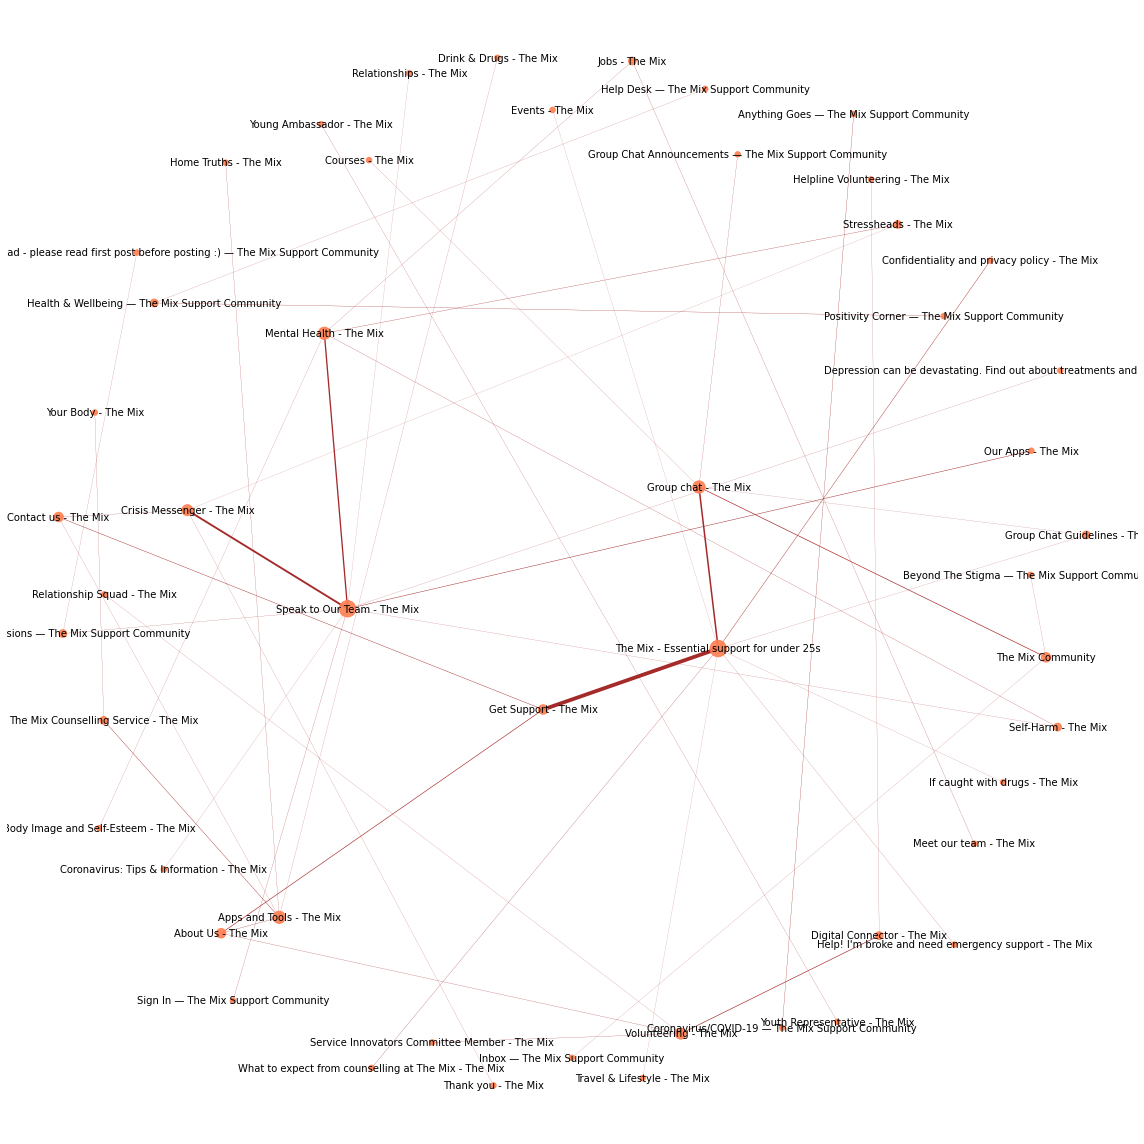

In [202]:
plot_network(G_pagegraph, 30, 10, 6)

## Apriori algorithm and Association rules

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from pandas.plotting import parallel_coordinates

PROJECT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_name, tight_layout=False, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_name + "." + fig_extension)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution, bbox_inches="tight")
    print("Figure saved,", fig_name)

In [2]:
# Load data
pageviews = pd.read_csv("./cleaned.csv", parse_dates=['datetime'])[['uid', 'page', 'pageURL', 'datetime']]
# Create a column ranking pageview sequence
pageviews['pageview_sequence'] = pageviews.groupby(['uid'])['datetime'].rank(method='first')

In [3]:
def get_pageviews_list(df):
    pageviews_list = []
    for uid in df.uid.unique():
        temp = df[df['uid'] == uid].sort_values(by='pageview_sequence')
        pageviews_list.append(list(temp.page.values))
    return pageviews_list

In [4]:
pageviews_list = get_pageviews_list(pageviews)

In [5]:
pageviews_list[0:5]

[['If caught with drugs - The Mix'],
 ['Taking someone to small claims court - The Mix',
  'Being taken to small claims court - The Mix'],
 ['Fingering a girl - TheMix.org.uk',
  'Why does she bleed when I finger her? - TheMix.org.uk'],
 ['General chit chat (OP GreenTea) - Page 542 — The Mix Support Community',
  'The Mix Community',
  'Speak to Our Team - The Mix',
  'The Mix Counselling Service - The Mix',
  'Thank you - The Mix'],
 ['The Mix Counselling Service - The Mix',
  'Get Support - The Mix',
  'Launching: The Kindness Diary - The Mix']]

In [6]:
# Instantiate encoder and identify unique items
encoder = TransactionEncoder().fit(pageviews_list)

# One-hot encode transactions
onehot = encoder.transform(pageviews_list)

# Convert one-hot encoded data to DataFrame
onehot = pd.DataFrame(onehot, columns=encoder.columns_)

In [7]:
frequent_itemsets = apriori(onehot, min_support=0.02, use_colnames=True, max_len=2)
rules = association_rules(frequent_itemsets, metric='support', min_threshold=0.00)

In [8]:
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(The Mix - Essential support for under 25s),(About Us - The Mix),0.313033,0.034800,0.029219,0.093340,2.682213,0.018325,1.064567
1,(About Us - The Mix),(The Mix - Essential support for under 25s),0.034800,0.313033,0.029219,0.839623,2.682213,0.018325,4.283438
2,(Health & Wellbeing — The Mix Support Community),(Anything Goes — The Mix Support Community),0.048260,0.043500,0.024458,0.506803,11.650725,0.022359,1.939387
3,(Anything Goes — The Mix Support Community),(Health & Wellbeing — The Mix Support Community),0.043500,0.048260,0.024458,0.562264,11.650725,0.022359,2.174234
4,(The Mix Community),(Anything Goes — The Mix Support Community),0.123441,0.043500,0.037919,0.307181,7.061682,0.032549,1.380592


Figure saved, heatmap


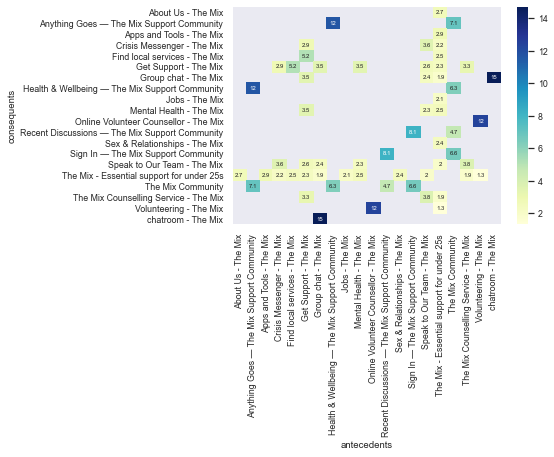

In [9]:
# Replace frozen sets with strings
rules['antecedents'] = rules['antecedents'].apply(lambda a: ','.join(list(a)))
rules['consequents'] = rules['consequents'].apply(lambda a: ','.join(list(a)))
# Transform data to matrix format and generate heatmap
pivot = rules.pivot_table(index='consequents', columns='antecedents', values='lift')

sns.set(font_scale=0.8)
sns.heatmap(pivot, cmap='YlGnBu', annot=True, annot_kws={"fontsize":6})
# Format and display plot
plt.yticks(rotation=0)
save_fig('heatmap')
plt.show()

In [10]:
frequent_itemsets = apriori(onehot, min_support=0.02, use_colnames=True, max_len=2)
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=2.5)

In [11]:
# Convert rules to coordinates. 
rules['antecedent'] = rules['antecedents'].apply(lambda antecedent: list(antecedent)[0]) 
rules['consequent'] = rules['consequents'].apply(lambda consequent: list(consequent)[0]) 
rules['rule'] = rules.index 

In [12]:
# Define coordinates and label
coords = rules[['antecedent','consequent','rule']] 
coords.head()

,antecedent,consequent,rule
0,The Mix - Essential support for under 25s,About Us - The Mix,0
1,About Us - The Mix,The Mix - Essential support for under 25s,1
2,Health & Wellbeing — The Mix Support Community,Anything Goes — The Mix Support Community,2
3,Anything Goes — The Mix Support Community,Health & Wellbeing — The Mix Support Community,3
4,The Mix Community,Anything Goes — The Mix Support Community,4


Figure saved, parallel


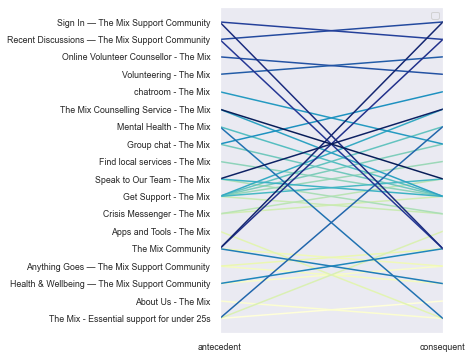

In [13]:
plt.figure(figsize=(4,6))
parallel_coordinates(coords, 'rule', colormap='YlGnBu',)
plt.legend([])
save_fig('parallel')
plt.show()

In [3]:
import pandas as pd
pageviews = pd.read_csv("./cleaned.csv", parse_dates=['datetime'])[['uid', 'page', 'pageURL', 'datetime']]
pageviews.uid.nunique()

6092

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates

PROJECT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_name, tight_layout=False, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_name + "." + fig_extension)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution, bbox_inches="tight")
    print("Figure saved,", fig_name)

In [3]:
# Load data
pageviews = pd.read_csv("./cleaned.csv", parse_dates=['datetime'])[['uid', 'page', 'pageURL', 'datetime']]

In [4]:
pageviews

,uid,page,pageURL,datetime
0,06ad34da38ae4e93bae9839fa38e5c2f,If caught with drugs - The Mix,/drink-and-drugs/drugs-and-the-law/if-caught-w...,2021-01-08 15:26:00
1,000708d176f8010cb95adfa271ad797d,Being taken to small claims court - The Mix,/crime-and-safety/in-trouble/being-taken-to-sm...,2021-01-24 02:00:00
2,000708d176f8010cb95adfa271ad797d,Taking someone to small claims court - The Mix,/money/money-rights/taking-someone-to-small-cl...,2021-01-24 01:59:00
3,001291be71d38604bc02f7c469b80704,Fingering a girl - TheMix.org.uk,/sex-and-relationships/having-sex/fingering-a-...,2020-10-22 04:03:00
4,001291be71d38604bc02f7c469b80704,Why does she bleed when I finger her? - TheMix...,/sex-and-relationships/having-sex/why-does-she...,2020-10-22 04:08:00
...,...,...,...,...
32790,ffe0ebe625dc3376651625a1319a48f2,Get Support - The Mix,/get-support,2020-09-21 19:08:00
32791,ffe0ebe625dc3376651625a1319a48f2,Speak to Our Team - The Mix,/get-support/speak-to-our-team,2020-09-21 19:09:00
32792,ffe0ebe625dc3376651625a1319a48f2,Crisis Messenger - The Mix,/get-support/speak-to-our-team/crisis-messenger,2020-09-20 20:06:00
32793,fff997e0a8ceb58da5a6eb0a4d8fbbc5,Is my penis normal? - TheMix.org.uk,/sex-and-relationships/having-sex/is-my-penis-...,2020-10-06 05:54:00
